**Student Name:** Yong Hen Tan

**Student Number:** 22273433

In [124]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Task 2

* Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with insurance.csv and draw conclusions from the results you observe in a markdown cell. 
* Add a third regression algorithm of your choice.
* Describe how it compares to Random Forest and Linear regression in a markdown cell (max 250 words in a markdown cell).

In [125]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [126]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [127]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [128]:
df['smoker'].value_counts()


no     1064
yes     274
Name: smoker, dtype: int64

In [129]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

<AxesSubplot:>

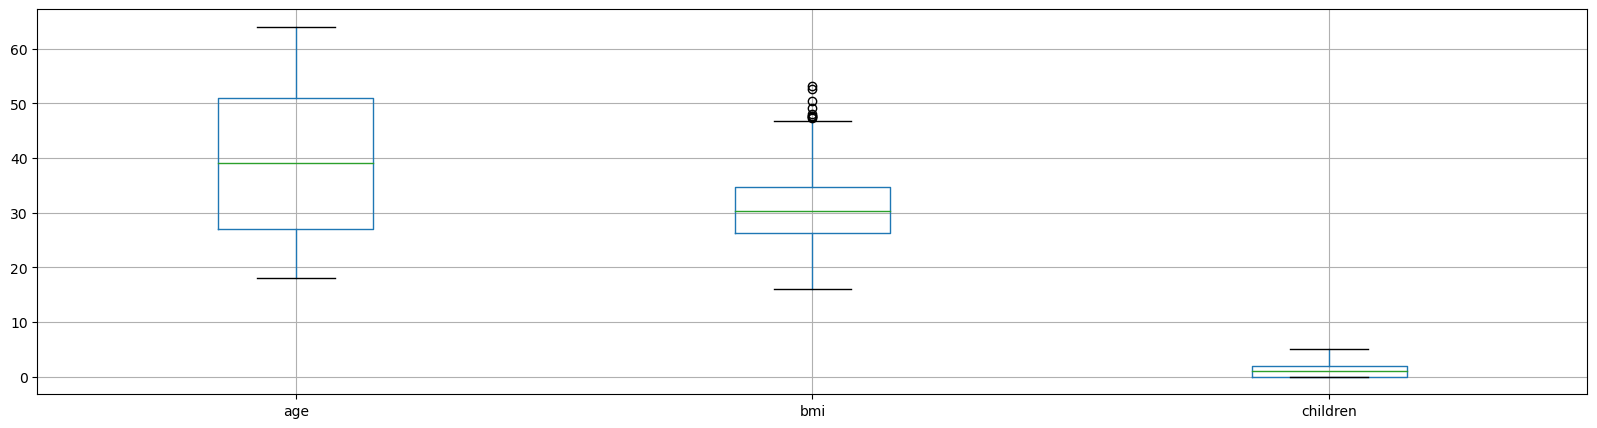

In [130]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))

Little outliers in `bmi`, not significant, so I will leave it

<AxesSubplot:>

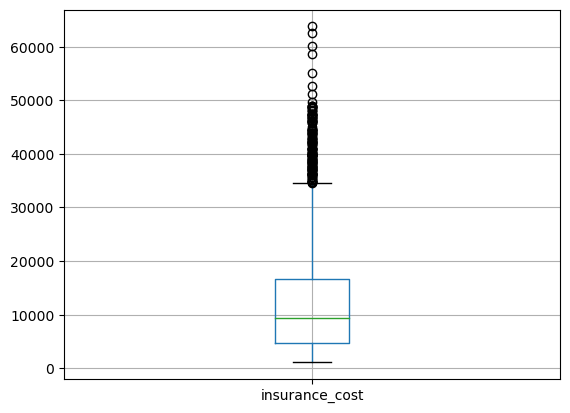

In [131]:
df.boxplot(column=['insurance_cost'])

<AxesSubplot:>

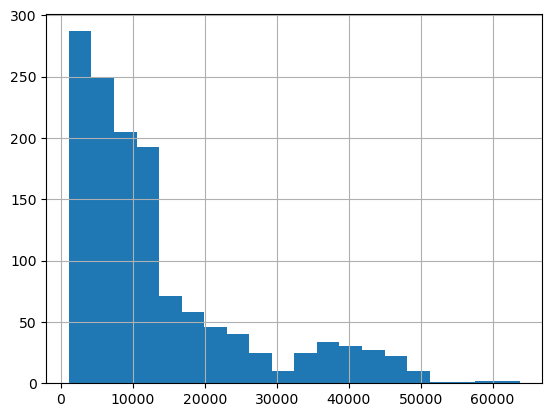

In [132]:
df['insurance_cost'].hist(bins=20)

There is significant outliers in insurance_cost. Will use log transformation to treat outliers.

### Data Preparation

#### Categorical to Numerical

In [133]:
df = pd.get_dummies(df, columns=['region', 'gender', 'smoker'])
df

age     bmi  children  insurance_cost  region_northeast  \
0      18  33.770         1      1725.55230                 0   
1      18  34.100         0      1137.01100                 0   
2      18  26.315         0      2198.18985                 1   
3      18  38.665         2      3393.35635                 1   
4      18  35.625         0      2211.13075                 1   
...   ...     ...       ...             ...               ...   
1333   64  31.825         2     16069.08475                 1   
1334   64  26.885         0     29330.98315                 0   
1335   64  26.410         0     14394.55790                 1   
1336   64  36.960         2     49577.66240                 0   
1337   64  23.760         0     26926.51440                 0   

      region_northwest  region_southeast  region_southwest  gender_female  \
0                    0                 1                 0              0   
1                    0                 1                 0              0   
2                    0                 0                 0              1   
3                    0                 0                 0              1   
4                    0                 0                 0              1   
...                ...               ...               ...            ...   
1333                 0                 0                 0              1   
1334                 1                 0                 0              1   
1335                 0                 0                 0              0   
1336                 0                 1                 0              0   
1337                 0                 1                 0              0   

      gender_male  smoker_no  smoker_yes  
0               1          1           0  
1               1          1           0  
2               0          1           0  
3               0          1           0  
4               0          1           0  
...           ...        ...         ...  
1333            0          1           0  
1334            0          0           1  
1335            1          1           0  
1336            1          0           1  
1337            1          0           1  

[1338 rows x 12 columns]

In [134]:
preprocess_pipeline = make_pipeline(StandardScaler())

In [135]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print(X_train.shape)
print(y_train.shape)

(1070, 11)
(1070,)


## Grid Search

### Random Forest Regressor

In [136]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('regresson', RandomForestRegressor())])

MAX_DEPTH_OPTIONS = range(2, 15)
MIN_SAMPLE_SPLITS_OPTIONS = range(2,6)


param_grid = [
    {
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__min_samples_split': MIN_SAMPLE_SPLITS_OPTIONS
    },
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.865:
Best parameters:  {'regresson__max_depth': 4, 'regresson__min_samples_split': 2}


### Linear Regression

In [137]:
from sklearn.model_selection import cross_val_score

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('linear_regression', LinearRegression())])

scores = cross_val_score(pipe, X_train, y_train, cv=5)
scores

array([0.76907113, 0.70351676, 0.78073933, 0.76439817, 0.70037509])

In [138]:
LR_model = pipe.fit(X_train, y_train)
LR_model.score(X_test, y_test)

0.7281744283924818

In [139]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

### 3rd Model (GradientBoostingRegressor)

In [140]:
from sklearn.ensemble import GradientBoostingRegressor

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('gradient_boosting_regressor', GradientBoostingRegressor())])


LOSS = ['squared_error', 'absolute_error', 'huber', 'quantile']
CRITERION = ['friedman_mse', 'squared_error']
MAX_FEATURES = ['sqrt', 'log2']


param_grid = [
    {
        'gradient_boosting_regressor__loss': LOSS,
        'gradient_boosting_regressor__criterion': CRITERION,
        'gradient_boosting_regressor__max_features': MAX_FEATURES
    },
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

GB_best_params = search.best_params_
GB_best_model = search.best_estimator_

Best CV score = 0.862:
Best parameters:  {'gradient_boosting_regressor__criterion': 'squared_error', 'gradient_boosting_regressor__loss': 'squared_error', 'gradient_boosting_regressor__max_features': 'sqrt'}


### Evaluate all models

In [141]:
GB_mse_without_dimen_reduc, GB_mae_without_dimen_reduc, GB_r2_without_dimen_reduc = evaluate_model(X_test, y_test, GB_best_model)
RF_mse_without_dimen_reduc, RF_mae_without_dimen_reduc, RF_r2_without_dimen_reduc = evaluate_model(X_test, y_test, RF_best_model)
LR_mse_without_dimen_reduc, LR_mae_without_dimen_reduc, LR_r2_without_dimen_reduc = evaluate_model(X_test, y_test, LR_model)


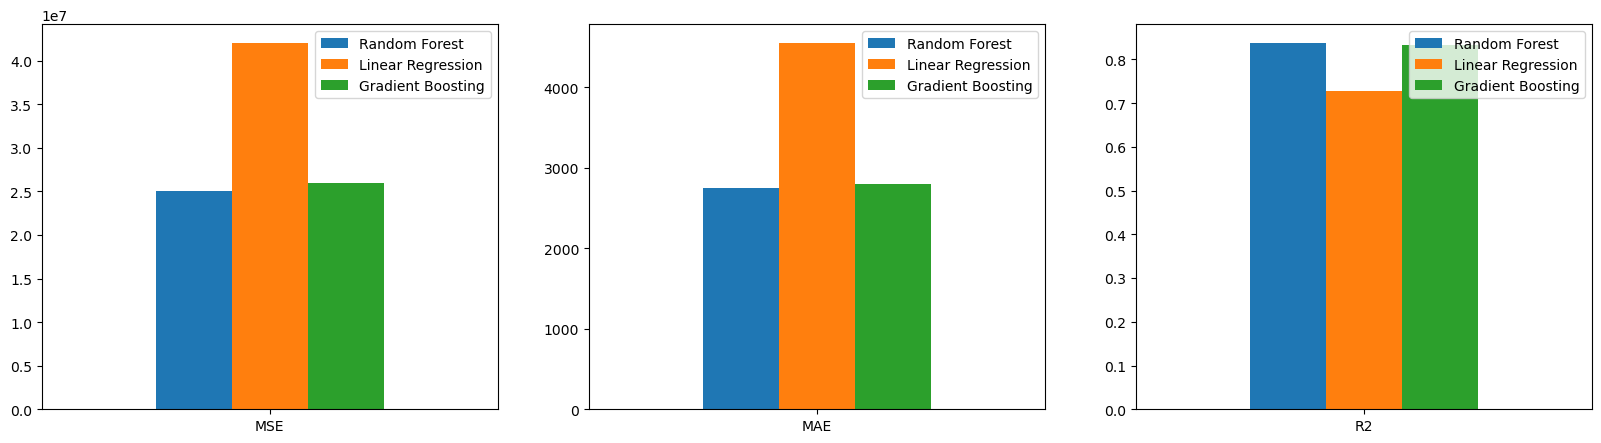

In [142]:
df_mse = pd.DataFrame({'Random Forest': RF_mse_without_dimen_reduc, 'Linear Regression': LR_mse_without_dimen_reduc, 'Gradient Boosting': GB_mse_without_dimen_reduc}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae_without_dimen_reduc, 'Linear Regression': LR_mae_without_dimen_reduc, 'Gradient Boosting': GB_mae_without_dimen_reduc}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2_without_dimen_reduc, 'Linear Regression': LR_r2_without_dimen_reduc, 'Gradient Boosting': GB_r2_without_dimen_reduc}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [143]:
print("Gradient Boosting Test Data Score: ", GB_best_model.score(X_test, y_test))
print("Random Forest Test Data Score: ", RF_best_model.score(X_test, y_test))
print("Linear Regression Test Data Score: ", LR_model.score(X_test, y_test))


Gradient Boosting Test Data Score:  0.8323558115331811
Random Forest Test Data Score:  0.8383942985196353
Linear Regression Test Data Score:  0.7281744283924818


# Task 3

* Add two dimensionality-reduction methods which are not used in CS5062 - Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines for insurance.csv. 
* Aim at dimensionality reduction techniques that are sufficiently different from the ones used in the example notebook.
* Draw conclusions from the results you observe in a markdown cell (max 250 words in a markdown cell).

In [144]:
dimen_reduc_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                                          ('reduce_dim', 'passthrough'),
                                          ('regresson', RandomForestRegressor(n_estimators=10))])

In [145]:
from sklearn import cluster
from sklearn.decomposition import TruncatedSVD

FA_N_CLUSTERS = range(2, 12)
FA_LINKAGE = ['ward', 'complete', 'average', 'single']

SVD_N_COMPONENTS = range(2,11)
SVD_ALGORITHM = ['arpack', 'randomized']
MAX_DEPTH_OPTIONS = range(2, 15)
MIN_SAMPLE_SPLITS_OPTIONS = range(2,6)

param_grid = [
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': FA_N_CLUSTERS,
        'reduce_dim__linkage': FA_LINKAGE,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__min_samples_split': MIN_SAMPLE_SPLITS_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': SVD_N_COMPONENTS,
        'reduce_dim__algorithm': SVD_ALGORITHM,
        'regresson__max_depth': MAX_DEPTH_OPTIONS,
        'regresson__min_samples_split': MIN_SAMPLE_SPLITS_OPTIONS
    }
]

search = GridSearchCV(dimen_reduc_pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.865:
Best parameters:  {'reduce_dim': FeatureAgglomeration(linkage='single', n_clusters=11), 'reduce_dim__linkage': 'single', 'reduce_dim__n_clusters': 11, 'regresson__max_depth': 4, 'regresson__min_samples_split': 3}


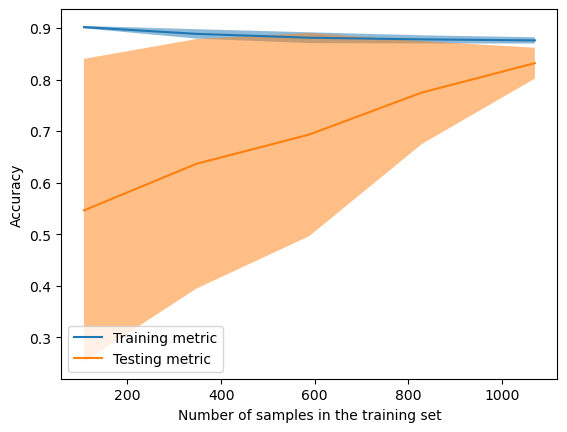

In [146]:
from sklearn.model_selection import LearningCurveDisplay

plot = LearningCurveDisplay.from_estimator(RF_best_model, X, y, cv=5, score_name='Accuracy', score_type="both")

In [147]:
from sklearn.ensemble import GradientBoostingRegressor

dimen_reduc_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                                          ('reduce_dim', 'passthrough'),
                                          ('gradient_boosting_regressor', GradientBoostingRegressor())])


LOSS = ['squared_error', 'absolute_error', 'huber', 'quantile']
CRITERION = ['friedman_mse', 'squared_error']
MAX_FEATURES = ['sqrt', 'log2']


param_grid = [
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': FA_N_CLUSTERS,
        'reduce_dim__linkage': FA_LINKAGE,
        'gradient_boosting_regressor__loss': LOSS,
        'gradient_boosting_regressor__criterion': CRITERION,
        'gradient_boosting_regressor__max_features': MAX_FEATURES
    },
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': SVD_N_COMPONENTS,
        'reduce_dim__algorithm': SVD_ALGORITHM,
        'gradient_boosting_regressor__loss': LOSS,
        'gradient_boosting_regressor__criterion': CRITERION,
        'gradient_boosting_regressor__max_features': MAX_FEATURES
    },
]

search = GridSearchCV(dimen_reduc_pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

GB_best_params = search.best_params_
GB_best_model = search.best_estimator_

Best CV score = 0.865:
Best parameters:  {'gradient_boosting_regressor__criterion': 'squared_error', 'gradient_boosting_regressor__loss': 'squared_error', 'gradient_boosting_regressor__max_features': 'sqrt', 'reduce_dim': FeatureAgglomeration(linkage='average', n_clusters=11), 'reduce_dim__linkage': 'average', 'reduce_dim__n_clusters': 11}


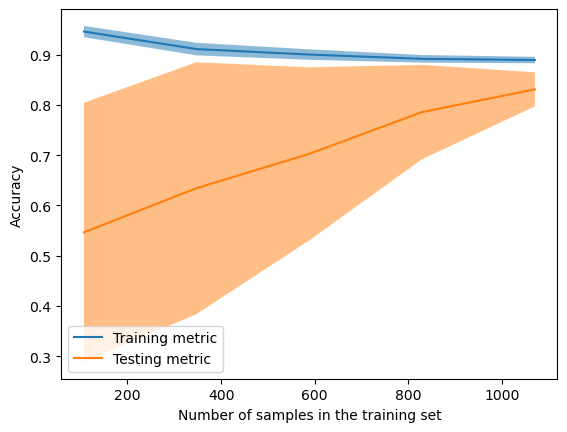

In [148]:
plot = LearningCurveDisplay.from_estimator(GB_best_model, X, y, cv=5, score_name='Accuracy', score_type="both")

In [149]:
dimen_reduc_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
                       ('reduce_dim', 'passthrough'), 
                       ('linear_regression', LinearRegression())])

param_grid = [
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': FA_N_CLUSTERS,
        'reduce_dim__linkage': FA_LINKAGE
    },
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': SVD_N_COMPONENTS,
        'reduce_dim__algorithm': SVD_ALGORITHM
    },
]

search = GridSearchCV(dimen_reduc_pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.747:
Best parameters:  {'reduce_dim': FeatureAgglomeration(linkage='average', n_clusters=11), 'reduce_dim__linkage': 'average', 'reduce_dim__n_clusters': 11}


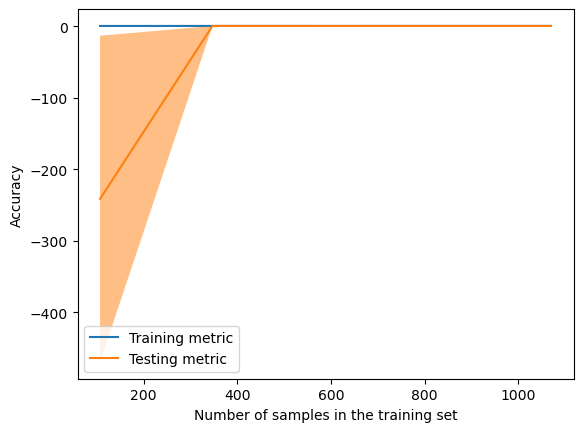

In [150]:
plot = LearningCurveDisplay.from_estimator(LR_best_model, X, y, cv=5, score_name='Accuracy', score_type="both")

In [151]:
print("Gradient Boosting + DimenReduction Test Data Score: ", GB_best_model.score(X_test, y_test))
print("Random Forest + DimenReduction Test Data Score: ", RF_best_model.score(X_test, y_test))
print("Linear Regression + DimenReduction Test Data Score: ", LR_model.score(X_test, y_test))

Gradient Boosting + DimenReduction Test Data Score:  0.8319077102799449
Random Forest + DimenReduction Test Data Score:  0.8357299786309021
Linear Regression + DimenReduction Test Data Score:  0.7281744283924818


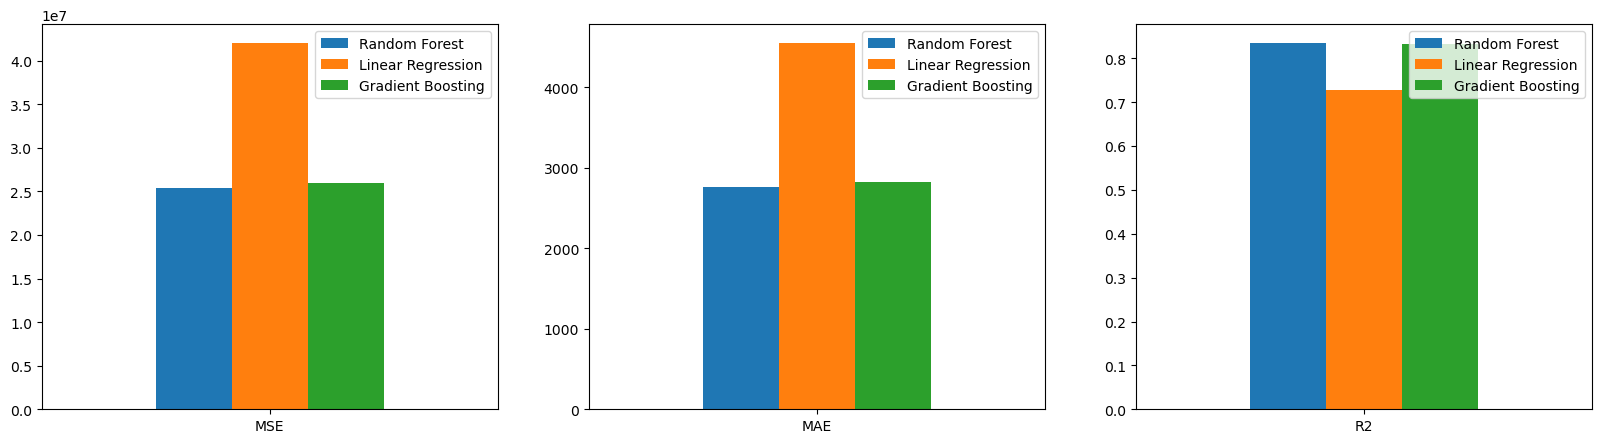

In [152]:
GB_mse_with_dimen_reduc, GB_mae_with_dimen_reduc, GB_r2_with_dimen_reduc = evaluate_model(X_test, y_test, GB_best_model)
RF_mse_with_dimen_reduc, RF_mae_with_dimen_reduc, RF_r2_with_dimen_reduc = evaluate_model(X_test, y_test, RF_best_model)
LR_mse_with_dimen_reduc, LR_mae_with_dimen_reduc, LR_r2_with_dimen_reduc = evaluate_model(X_test, y_test, LR_model)


df_mse = pd.DataFrame({'Random Forest': RF_mse_with_dimen_reduc, 'Linear Regression': LR_mse_with_dimen_reduc, 'Gradient Boosting': GB_mse_with_dimen_reduc}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae_with_dimen_reduc, 'Linear Regression': LR_mae_with_dimen_reduc, 'Gradient Boosting': GB_mae_with_dimen_reduc}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2_with_dimen_reduc, 'Linear Regression': LR_r2_with_dimen_reduc, 'Gradient Boosting': GB_r2_with_dimen_reduc}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

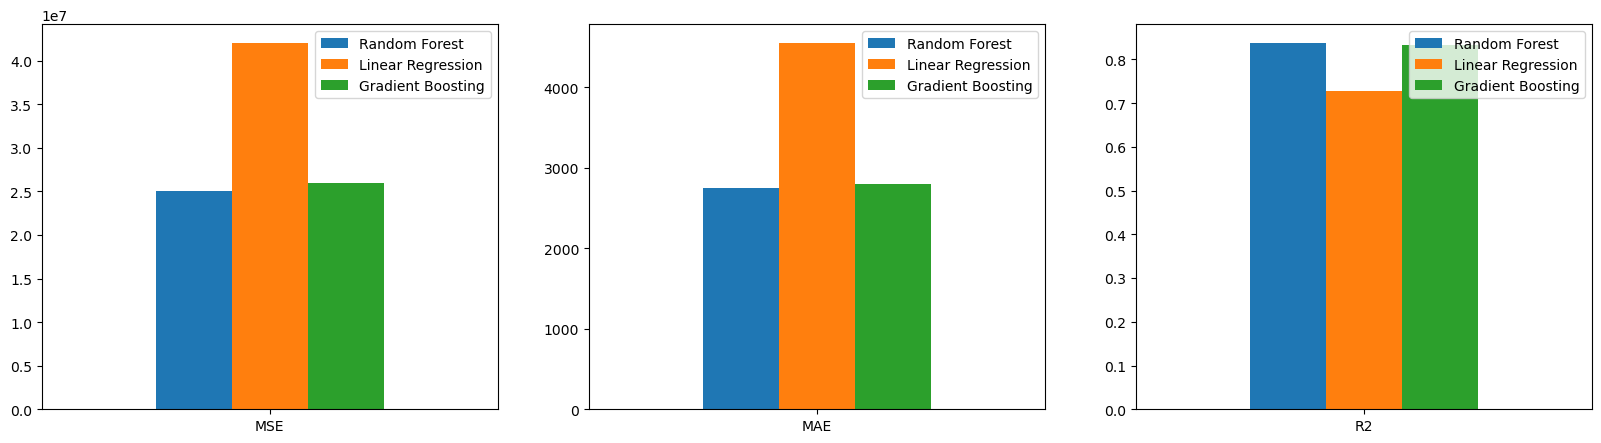

In [153]:
df_mse = pd.DataFrame({'Random Forest': RF_mse_without_dimen_reduc, 'Linear Regression': LR_mse_without_dimen_reduc, 'Gradient Boosting': GB_mse_without_dimen_reduc}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae_without_dimen_reduc, 'Linear Regression': LR_mae_without_dimen_reduc, 'Gradient Boosting': GB_mae_without_dimen_reduc}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2_without_dimen_reduc, 'Linear Regression': LR_r2_without_dimen_reduc, 'Gradient Boosting': GB_r2_without_dimen_reduc}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()